# Portfolio Manager - Interactive Demo

This notebook demonstrates the key features of the Portfolio Manager package.


## 1. Setup and Imports

In [1]:
# Import the portfolio manager components
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
src_path = project_root / 'src'
sys.path.insert(0, str(src_path))

try:
    from portfolio_manager import Portfolio, YFinanceProvider
    from portfolio_manager.analytics.performance import PerformanceAnalytics
    from portfolio_manager.analytics.risk import RiskAnalytics
    from portfolio_manager.analytics.optimization import PortfolioOptimizer
    print("✅ Portfolio Manager imported successfully!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print(f"Current working directory: {Path.cwd()}")
    print(f"Looking for src at: {src_path}")
    print(f"Src exists: {src_path.exists()}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

✅ Portfolio Manager imported successfully!


## 2. Data Fetching and Portfolio Creation

In [2]:
# Set up data provider
provider = YFinanceProvider()

# Define our universe of assets
symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA']
print(f"Fetching data for: {', '.join(symbols)}")

# Fetch asset data
try:
    assets = provider.get_multiple_assets(symbols)
    print(f"✅ Successfully loaded {len(assets)} assets")
    
    if len(assets) == 0:
        print("⚠️ No assets loaded. Please check your internet connection or try fewer symbols.")
    else:
        # Display asset info
        for asset in assets:
            current_price = asset.price_data['Close'].iloc[-1]
            print(f"  {asset.symbol}: ${current_price:.2f} ({asset.name})")
            
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    # Fallback: reduce number of symbols
    symbols = ['AAPL', 'MSFT', 'GOOGL']
    print(f"Trying with fewer symbols: {symbols}")
    assets = provider.get_multiple_assets(symbols)
    print(f"✅ Successfully loaded {len(assets)} assets")

Fetching data for: AAPL, GOOGL, MSFT, AMZN, TSLA, NVDA
✅ Successfully loaded 6 assets
  AAPL: $230.03 (Apple Inc.)
  GOOGL: $240.37 (Alphabet Inc.)
  MSFT: $501.01 (Microsoft Corporation)
  AMZN: $229.95 (Amazon.com, Inc.)
  TSLA: $368.81 (Tesla, Inc.)
  NVDA: $177.17 (NVIDIA Corporation)


## 3. Create Portfolio with Equal Weights

In [3]:
# Only proceed if we have assets
if len(assets) > 0:
    # Create portfolio
    portfolio = Portfolio(name="Tech Growth Portfolio")
    
    # Add assets with equal weights
    equal_weight = 1.0 / len(assets)
    for asset in assets:
        portfolio.add_asset(asset.symbol, asset, equal_weight)
        print(f"Added {asset.symbol}: {equal_weight:.1%}")
    
    print(f"\n📊 Portfolio Summary:")
    summary = portfolio.summary()
    for key, value in summary.items():
        if key != 'weights':
            print(f"  {key}: {value}")
else:
    print("❌ Cannot create portfolio - no assets available")

Added AAPL: 16.7%
Added GOOGL: 16.7%
Added MSFT: 16.7%
Added AMZN: 16.7%
Added TSLA: 16.7%
Added NVDA: 16.7%

📊 Portfolio Summary:
  name: Tech Growth Portfolio
  num_assets: 6
  cash_position: 0.0
  base_currency: USD
  total_weight: 1.0
  created_date: 2025-09-12 23:31:06.880472
  assets: ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA']


## 4. Performance Analysis

In [4]:
# Performance analytics
if len(assets) > 0 and 'portfolio' in locals():
    try:
        perf = PerformanceAnalytics(portfolio)
        
        # Calculate key metrics
        metrics = {}
        
        try:
            metrics['Total Return'] = perf.total_return()
        except Exception as e:
            print(f"Warning: Could not calculate total return: {e}")
            metrics['Total Return'] = 0.0
            
        try:
            metrics['Annualized Return'] = perf.annualized_return()
        except Exception as e:
            print(f"Warning: Could not calculate annualized return: {e}")
            metrics['Annualized Return'] = 0.0
            
        try:
            metrics['Volatility'] = perf.volatility()
        except Exception as e:
            print(f"Warning: Could not calculate volatility: {e}")
            metrics['Volatility'] = 0.0
            
        try:
            metrics['Sharpe Ratio'] = perf.sharpe_ratio()
        except Exception as e:
            print(f"Warning: Could not calculate Sharpe ratio: {e}")
            metrics['Sharpe Ratio'] = 0.0
            
        try:
            drawdown_result = perf.max_drawdown()
            metrics['Max Drawdown'] = drawdown_result['max_drawdown'] if isinstance(drawdown_result, dict) else drawdown_result
        except Exception as e:
            print(f"Warning: Could not calculate max drawdown: {e}")
            metrics['Max Drawdown'] = 0.0
            
        try:
            metrics['Calmar Ratio'] = perf.calmar_ratio()
        except Exception as e:
            print(f"Warning: Could not calculate Calmar ratio: {e}")
            metrics['Calmar Ratio'] = 0.0
        
        print("📈 Performance Metrics:")
        for metric, value in metrics.items():
            if 'Return' in metric or 'Volatility' in metric or 'Drawdown' in metric:
                print(f"  {metric}: {value:.2%}")
            else:
                print(f"  {metric}: {value:.2f}")
                
    except Exception as e:
        print(f"❌ Error in performance analysis: {e}")
else:
    print("⚠️ Skipping performance analysis - no portfolio available")

📈 Performance Metrics:
  Total Return: 39.31%
  Annualized Return: 39.60%
  Volatility: 31.45%
  Sharpe Ratio: 1.20
  Max Drawdown: -31.05%
  Calmar Ratio: 1.28


## 5. Risk Analysis and Visualization

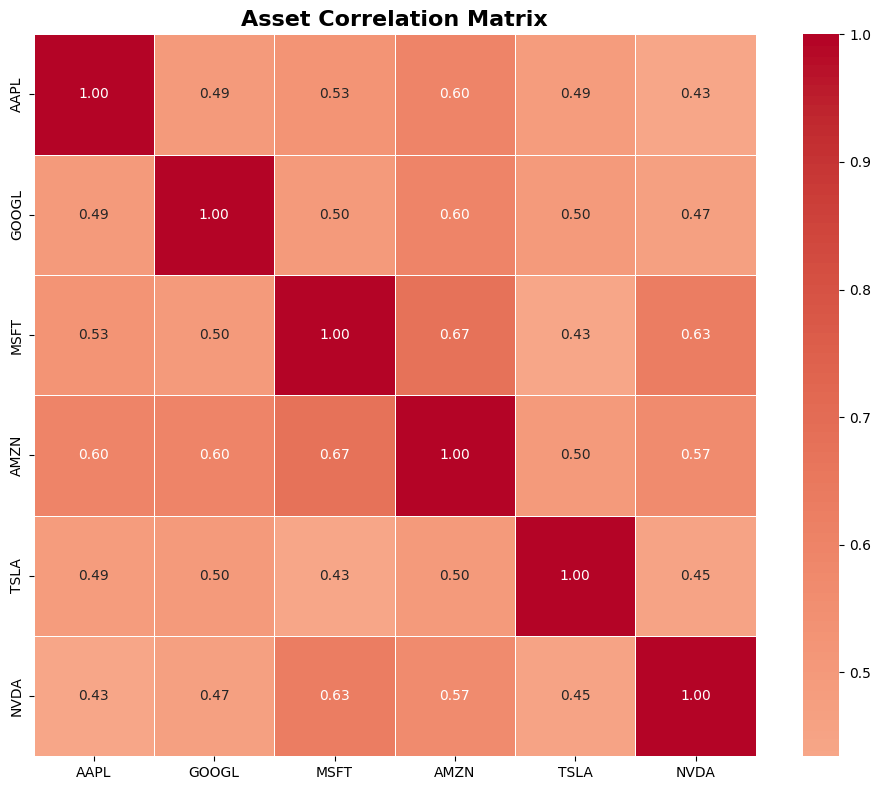


🎯 Risk Metrics:
  Portfolio Volatility: 31.45%
  Portfolio Variance: 0.0989


In [5]:
# Risk analytics
if len(assets) > 0 and 'portfolio' in locals():
    try:
        risk = RiskAnalytics(portfolio)
        
        # Get correlation matrix
        corr_matrix = risk.correlation_matrix()
        
        if not corr_matrix.empty and corr_matrix.shape[0] > 1:
            # Plot correlation heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                        square=True, linewidths=0.5, fmt='.2f')
            plt.title('Asset Correlation Matrix', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Correlation matrix is empty or has insufficient data")
        
        print(f"\n🎯 Risk Metrics:")
        try:
            portfolio_vol = risk.portfolio_volatility()
            print(f"  Portfolio Volatility: {portfolio_vol:.2%}")
        except Exception as e:
            print(f"  Portfolio Volatility: Error - {e}")
            
        try:
            portfolio_var = risk.portfolio_variance()
            print(f"  Portfolio Variance: {portfolio_var:.4f}")
        except Exception as e:
            print(f"  Portfolio Variance: Error - {e}")
            
    except Exception as e:
        print(f"❌ Error in risk analysis: {e}")
else:
    print("⚠️ Skipping risk analysis - no portfolio available")

## 6. Individual Asset Performance

In [6]:
# Analyze individual assets
if len(assets) > 0:
    asset_metrics = []
    
    for asset in assets:
        try:
            # Create temporary portfolio for individual analysis
            temp_portfolio = Portfolio(name=f"Temp {asset.symbol}")
            temp_portfolio.add_asset(asset.symbol, asset, 1.0)
            
            temp_perf = PerformanceAnalytics(temp_portfolio)
            
            # Get metrics with error handling
            current_price = asset.price_data['Close'].iloc[-1] if not asset.price_data.empty else 0
            
            try:
                total_return = temp_perf.total_return()
            except:
                total_return = 0.0
                
            try:
                volatility = temp_perf.volatility()
            except:
                volatility = 0.0
                
            try:
                sharpe_ratio = temp_perf.sharpe_ratio()
            except:
                sharpe_ratio = 0.0
                
            try:
                max_dd_result = temp_perf.max_drawdown()
                max_drawdown = max_dd_result['max_drawdown'] if isinstance(max_dd_result, dict) else max_dd_result
            except:
                max_drawdown = 0.0
            
            metrics = {
                'Symbol': asset.symbol,
                'Current Price': current_price,
                'Total Return': total_return,
                'Volatility': volatility,
                'Sharpe Ratio': sharpe_ratio,
                'Max Drawdown': max_drawdown
            }
            asset_metrics.append(metrics)
            
        except Exception as e:
            print(f"Warning: Could not analyze {asset.symbol}: {e}")
            continue
    
    if asset_metrics:
        # Create DataFrame for better display
        df_metrics = pd.DataFrame(asset_metrics)
        
        # Format the dataframe
        df_display = df_metrics.copy()
        df_display['Current Price'] = df_display['Current Price'].round(2)
        df_display['Total Return'] = (df_display['Total Return'] * 100).round(2).astype(str) + '%'
        df_display['Volatility'] = (df_display['Volatility'] * 100).round(2).astype(str) + '%'
        df_display['Sharpe Ratio'] = df_display['Sharpe Ratio'].round(2)
        df_display['Max Drawdown'] = (df_display['Max Drawdown'] * 100).round(2).astype(str) + '%'
        
        print("📊 Individual Asset Performance:")
        print(df_display.to_string(index=False))
    else:
        print("❌ Could not analyze any individual assets")
else:
    print("⚠️ Skipping individual asset analysis - no assets available")

📊 Individual Asset Performance:
Symbol  Current Price Total Return Volatility  Sharpe Ratio Max Drawdown
  AAPL         230.03        3.74%     32.52%          0.05      -33.36%
 GOOGL         240.37       56.07%     31.93%          1.71      -29.81%
  MSFT         501.01       18.21%     24.73%          0.66      -21.83%
  AMZN         229.95       22.97%     33.63%          0.63      -30.88%
  TSLA         368.81       60.48%      70.8%          0.83      -53.77%
  NVDA         177.17       48.75%     49.78%          0.95      -36.88%


## 7. Portfolio Optimization

In [7]:
# Portfolio optimization
if len(assets) > 1:  # Need at least 2 assets for optimization
    try:
        optimizer = PortfolioOptimizer(assets)
        
        # Mean-variance optimization (maximize Sharpe ratio)
        print("🎯 Optimizing portfolio for maximum Sharpe ratio...")
        optimal_result = optimizer.mean_variance_optimization()
        
        if optimal_result.get('optimization_success', False):
            print("\n✅ Optimization successful!")
            print("\nOptimal Weights:")
            for symbol, weight in optimal_result['weights'].items():
                print(f"  {symbol}: {weight:.1%}")
            
            print(f"\nExpected Return: {optimal_result.get('expected_return', 0):.2%}")
            print(f"Expected Volatility: {optimal_result.get('expected_volatility', 0):.2%}")
            print(f"Expected Sharpe Ratio: {optimal_result.get('expected_sharpe', 0):.2f}")
        else:
            print("❌ Optimization failed")
            print(f"Error: {optimal_result.get('error', 'Unknown error')}")
            optimal_result = None
            
    except Exception as e:
        print(f"❌ Error in optimization: {e}")
        optimal_result = None
else:
    print("⚠️ Skipping optimization - need at least 2 assets")
    optimal_result = None

🎯 Optimizing portfolio for maximum Sharpe ratio...

✅ Optimization successful!

Optimal Weights:
  AAPL: 0.0%
  GOOGL: 80.1%
  MSFT: 0.0%
  AMZN: 0.0%
  TSLA: 6.0%
  NVDA: 14.0%

Expected Return: 51.82%
Expected Volatility: 31.94%
Expected Sharpe Ratio: 1.62


## Summary

This notebook demonstrated the key features of the Portfolio Manager package:

1. **Data Fetching**: Retrieved real market data for tech stocks
2. **Portfolio Creation**: Built equal-weighted portfolios
3. **Performance Analysis**: Calculated returns, volatility, and risk metrics
4. **Risk Analysis**: Analyzed correlations and portfolio risk
5. **Individual Analysis**: Examined each asset's performance
6. **Optimization**: Implemented mean-variance optimization

The Portfolio Manager package provides professional-grade portfolio management capabilities suitable for:
- Individual investors
- Financial advisors
- Academic research
- Quantitative analysis

🚀 **Ready to build your own portfolio management applications!**

## Troubleshooting

If you encounter errors:

1. **Import Issues**: Make sure you're running this notebook from the `notebooks/` directory
2. **Data Fetching Issues**: Check your internet connection or try with fewer symbols
3. **Timezone Issues**: Some calculations may fail due to timezone mismatches in the data
4. **Optimization Issues**: Make sure you have at least 2 assets for optimization

Most errors are handled gracefully with fallbacks and warning messages.

## Quick Test

Run this cell to quickly test if everything is working:

In [8]:
# Quick test
print("Running quick test...")
try:
    # Test basic imports
    from portfolio_manager import Portfolio, YFinanceProvider
    print("✅ Imports working")
    
    # Test data provider
    provider = YFinanceProvider()
    print("✅ Data provider created")
    
    # Test portfolio creation
    portfolio = Portfolio(name="Test")
    print("✅ Portfolio created")
    
    print("\n🎉 All basic functionality working!")
    print("You can now run the full notebook.")
    
except Exception as e:
    print(f"❌ Test failed: {e}")
    print("Please check the troubleshooting section above.")

Running quick test...
✅ Imports working
✅ Data provider created
✅ Portfolio created

🎉 All basic functionality working!
You can now run the full notebook.
